In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

SEED = 717
random.seed(SEED)
torch.manual_seed(SEED)

# Load Dataset

In [2]:
from google.colab import files
f = files.upload()

Saving Cora.zip to Cora.zip


In [3]:
!unzip Cora.zip

Archive:  Cora.zip
  inflating: Cora/edge.pt            
  inflating: Cora/feat.pt            
  inflating: Cora/label.pt           


# Preprocess Data

Load dataset files

In [4]:
edge = torch.load("./Cora/edge.pt")
edge = torch.transpose(edge, 0, 1)

feat = torch.load("./Cora/feat.pt").type(torch.float64)

label = torch.load("./Cora/label.pt")

print(f"# Nodes: {feat.shape[0]}")
print(f"# Edges: {edge.shape[0]}")

print(edge.shape)
print(feat.shape)
print(label.shape)

# Nodes: 2708
# Edges: 10556
torch.Size([10556, 2])
torch.Size([2708, 1433])
torch.Size([2708])


Count the number of nodes and the dimension of features

In [5]:
num_node = feat.shape[0]
dim_feat = feat.shape[1]
print(num_node, dim_feat)

2708 1433


Split the data into training, validation, and test sets

In [6]:
random.seed(SEED)

train_ratio = 0.8
valid_ratio = 0.1

train_end = int(train_ratio * num_node)
valid_end = train_end + int(valid_ratio * num_node)

idx_shuffle = list(range(num_node))
random.shuffle(idx_shuffle)

idx_train = idx_shuffle[:train_end]
idx_valid = idx_shuffle[train_end:valid_end]
idx_test = idx_shuffle[valid_end:]

print(f"# Train: {len(idx_train)} ({len(idx_train) / num_node * 100:.1f} %)")
print(f"# Valid: {len(idx_valid)} ({len(idx_valid) / num_node * 100:.1f} %)")
print(f"# Test: {len(idx_test)} ({len(idx_test) / num_node * 100:.1f} %)")

# Train: 2166 (80.0 %)
# Valid: 270 (10.0 %)
# Test: 272 (10.0 %)


Count the degree of each node

In [7]:
def calculate_degree(num_node: int, edge: torch.Tensor) -> torch.Tensor:

    heads = edge[:, 0]
    degree = torch.bincount(heads, minlength = num_node).type(torch.float64)
    return degree

In [8]:
degree = calculate_degree(num_node, edge)
print(degree)
print(degree.shape)
print(degree.sum(axis = 0))

tensor([3., 3., 5.,  ..., 1., 4., 4.], dtype=torch.float64)
torch.Size([2708])
tensor(10556., dtype=torch.float64)


# GraphSAGE Layer

In [9]:
class GraphSageLayer(nn.Module):

    def __init__(self, dim_in: int,
                 dim_out: int,
                 agg_type: str):

        super(GraphSageLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.agg_type = agg_type
        self.act = nn.ReLU()

        if self.agg_type == 'gcn':
            self.weight = nn.Linear(self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # W_l
            self.bias = nn.Linear(self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # B_l

        elif self.agg_type == 'mean':
            self.weight = nn.Linear(2 * self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # W_l

        elif self.agg_type == 'maxpool':
            self.linear_pool = nn.Linear(self.dim_in, self.dim_in, bias=True, dtype=torch.float64) # W_{pool}, b
            self.weight = nn.Linear(2 * self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # W_l

        else:
            raise RuntimeError(f"Unknown aggregation type: {self.agg_type}")

    def forward(self, feat: torch.Tensor,
                edge: torch.Tensor,
                degree: torch.Tensor) -> torch.Tensor:

        if self.agg_type == 'gcn':
            feat_h = feat[edge[:, 0]]
            idx_t = edge[:, 1]

            agg_neighbor = torch.zeros(feat.shape[0], feat.shape[1], dtype = torch.float64).cuda()
            agg_neighbor = agg_neighbor.index_add_(0, idx_t, feat_h)
            inv_degree = torch.where(degree == 0.0, 1.0, 1.0 / degree).unsqueeze(-1)
            feat_agg = agg_neighbor * inv_degree
            out = F.normalize(self.act(self.weight(feat_agg) + self.bias(feat)), 2, -1)

        elif self.agg_type == 'mean':
            feat_h = feat[edge[:, 0]]
            idx_t = edge[:, 1]

            agg_neighbor = torch.zeros(feat.shape[0], feat.shape[1], dtype = torch.float64).cuda()
            agg_neighbor = agg_neighbor.index_add_(0, idx_t, feat_h)
            inv_degree = torch.where(degree == 0.0, 1.0, 1.0 / degree).unsqueeze(-1)
            feat_agg = agg_neighbor * inv_degree
            out = F.normalize(self.act(self.weight(torch.cat((feat_agg, feat), 1))), 2, -1)

        elif self.agg_type == 'maxpool':
            feat_h = self.act(self.linear_pool(feat))
            feat_h = feat_h[edge[:, 0]]
            idx_t = edge[:, 1]

            scatter_idx = idx_t.unsqueeze(-1).repeat(1, feat.shape[1])
            feat_agg = torch.zeros(feat.shape[0], feat.shape[1], dtype=torch.float64).cuda()
            feat_agg = feat_agg.scatter_reduce(0, scatter_idx, feat_h, reduce = 'amax', include_self = False)
            out = F.normalize(self.act(self.weight(torch.cat((feat_agg, feat), 1))), 2, -1)

        else:
            raise RuntimeError(f"Unknown aggregation type: {self.agg_type}")

        return out

# GraphSAGE Model

In [10]:
class GraphSage(nn.Module):
    def __init__(self, num_layers: int,
                 dim_in: int,
                 dim_hidden: int,
                 dim_out: int,
                 agg_type: str):

        super(GraphSage, self).__init__()

        self.num_layers = num_layers
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.agg_type = agg_type
        self.layers = nn.ModuleList()
        for l in range(num_layers):
            self.layers.append(GraphSageLayer(self.dim_in if l == 0 else self.dim_hidden, self.dim_hidden, agg_type))

        self.classifier = nn.Linear(self.dim_hidden, self.dim_out, dtype=torch.float64)

    def forward(self, feat: torch.Tensor,
                edge: torch.Tensor,
                degree: torch.Tensor) -> torch.Tensor:
        x_in = feat
        for layer in self.layers:
            x_out = layer(x_in, edge, degree)
            x_in = x_out

        return self.classifier(x_out)

# Training

In [ ]:
feat = feat.cuda()
edge = edge.cuda()
degree = degree.cuda()

In [ ]:
from typing import List, Tuple

def train(model: nn.Module, agg_type: str,
          feat: torch.Tensor, edge: torch.Tensor,
          degree: torch.Tensor, label: torch.Tensor,
          idx_train: List[int], idx_valid: List[int],
          lr: float=0.0001, num_epoch: int=200) -> Tuple[List[float], List[float]]:

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    epoch_best = 0
    f1_val_best = 0.
    list_valid_f1 = []
    list_loss = []

    with tqdm(range(num_epoch), unit="epoch", desc="Training") as pbar:

        pbar.clear()
        for epoch in pbar:
            model.train()
            optimizer.zero_grad()
            y_true = label[idx_train]

            y_score = model(feat, edge, degree)

            loss = loss_fn(y_score[idx_train], y_true.cuda())

            loss.backward()
            optimizer.step()
            list_loss.append(loss.item())

            # Validation
            model.eval()
            with torch.no_grad():
                y_true = label[idx_valid]

                y_score = model(feat, edge, degree)

                _, y_pred = torch.max(y_score[idx_valid], 1)
                y_pred = y_pred.detach().cpu()

                f1_val = f1_score(y_true, y_pred, average= 'micro')

                list_valid_f1.append(float(f1_val))
                if f1_val > f1_val_best:
                    torch.save(model, f'model-{agg_type}.pt')
                    f1_val_best = f1_val
                    epoch_best = epoch

                postfix_new = ", ".join([f"f1_val: {f1_val:.4f} (best: {f1_val_best:.4f} - Epoch {epoch_best})",
                                         f"loss: {loss:.5f}"])
                pbar.set_postfix_str(postfix_new)

    return list_loss, list_valid_f1

In [ ]:
def visualize_train_history(num_epoch, list_loss, list_valid_f1, title) -> None:
    t = np.arange(num_epoch)
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    line1 = ax1.plot(t, list_loss, color='blue', label='Loss')

    ax2 = ax1.twinx()
    ax2.set_ylabel('F1 Score (Micro)')
    line2 = ax2.plot(t, list_valid_f1, color='orange', label='F1 Score (Micro)')

    lines = line1 + line2
    labels = [line.get_label() for line in lines]

    ax1.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.1, 1))

    plt.title(title)
    plt.show()

1. Train GCN

In [ ]:
torch.manual_seed(SEED)
model = GraphSage(2, dim_feat, 128, 7, 'gcn').cuda()
list_loss_gcn, list_valid_f1_gcn = train(model, 'gcn',
                                         feat, edge, degree, label,
                                         idx_train, idx_valid)

Training: 100%|██████████| 200/200 [00:17<00:00, 11.40epoch/s, f1_val: 0.8926 (best: 0.9037 - Epoch 169), loss: 1.44678]


Visualize train losses and valid F1 scores.

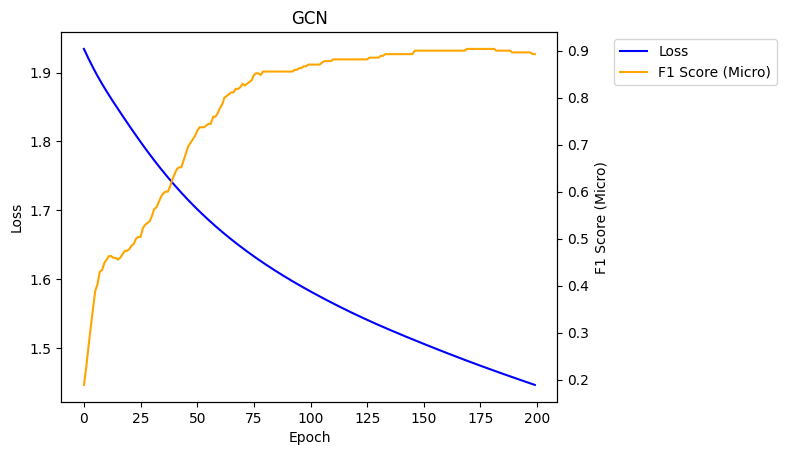

In [ ]:
visualize_train_history(200, list_loss_gcn, list_valid_f1_gcn,
                        title="GCN")

2. Train GraphSAGE(Mean)

In [ ]:
torch.manual_seed(SEED)
model = GraphSage(2, dim_feat, 128, 7, 'mean').cuda()
list_loss_mean, list_valid_f1_mean = train(model, 'mean',
                                           feat, edge, degree, label,
                                           idx_train, idx_valid)

Training: 100%|██████████| 200/200 [00:17<00:00, 11.65epoch/s, f1_val: 0.8963 (best: 0.9074 - Epoch 122), loss: 1.42945]


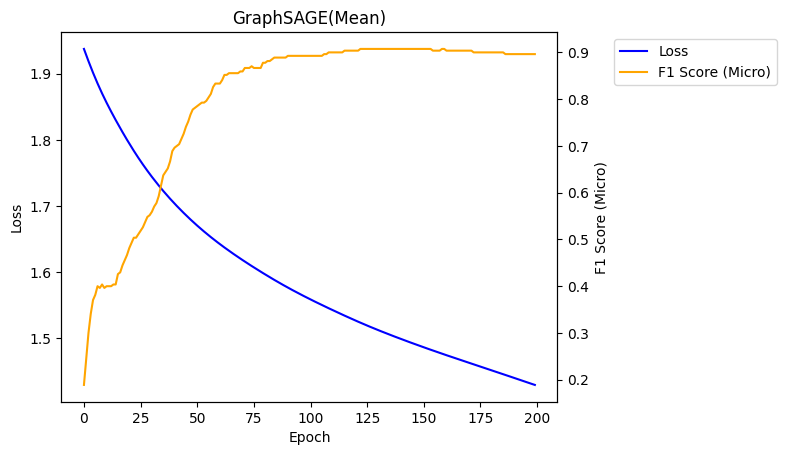

In [ ]:
visualize_train_history(200, list_loss_mean, list_valid_f1_mean,
                        title="GraphSAGE(Mean)")

3. Train GraphSAGE(Maxpool)

In [ ]:
torch.manual_seed(SEED)
model = GraphSage(2, dim_feat, 128, 7, 'maxpool').cuda()
list_loss_maxpool, list_valid_f1_maxpool = train(model, 'maxpool',
                                                 feat, edge, degree, label,
                                                 idx_train, idx_valid)

Training: 100%|██████████| 200/200 [00:51<00:00,  3.91epoch/s, f1_val: 0.9074 (best: 0.9074 - Epoch 73), loss: 1.43750]


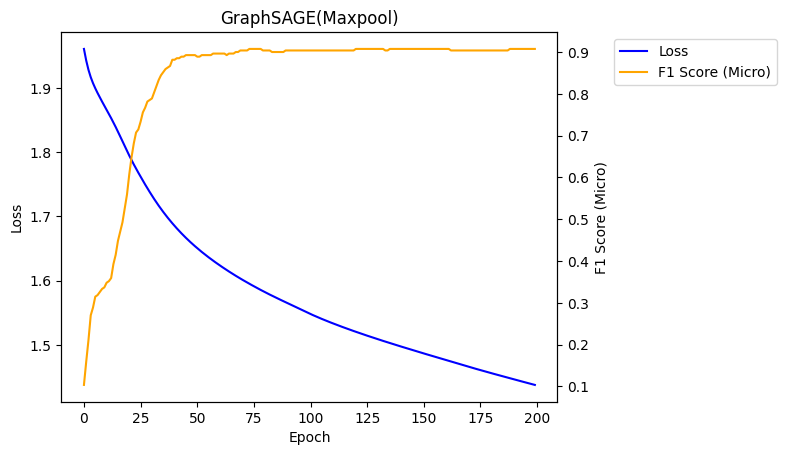

In [ ]:
visualize_train_history(200, list_loss_maxpool, list_valid_f1_maxpool,
                        title="GraphSAGE(Maxpool)")

# Evaluation

In [ ]:
def evaluate_node_classification(agg_type: str, feat: torch.Tensor, edge: torch.Tensor,
                                 degree: torch.Tensor, label: torch.Tensor,
                                 idx_test: List[int], title: str) -> None:

    model = torch.load(f"model-{agg_type}.pt")
    model.eval()

    y_true = label[idx_test]


    y_score = model(feat, edge, degree)

    _, y_pred = torch.max(y_score[idx_test], 1)
    y_pred = y_pred.detach().cpu()

    f1_test = f1_score(y_true, y_pred, average = 'micro')
    print(f"F1 Score: {f1_test:.4f}")


    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()

1. Evaluate the performance of GCN on the Cora dataset.

F1 Score: 0.8713


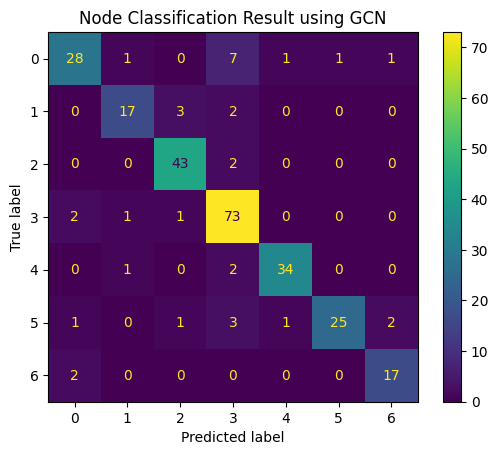

In [ ]:
evaluate_node_classification('gcn', feat, edge, degree, label, idx_test,
                             title="Node Classification Result using GCN")

2. Evaluate the performance of GraphSAGE(Mean) on the Cora dataset.

F1 Score: 0.8529


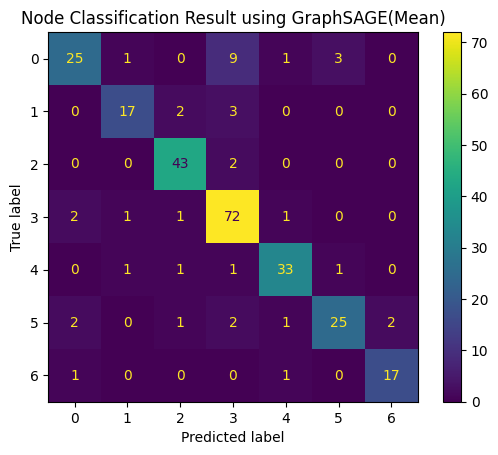

In [ ]:
evaluate_node_classification('mean', feat, edge, degree, label, idx_test,
                             title="Node Classification Result using GraphSAGE(Mean)")

3. Evaluate the performance of GraphSAGE(Maxpool) on the Cora dataset.

F1 Score: 0.8566


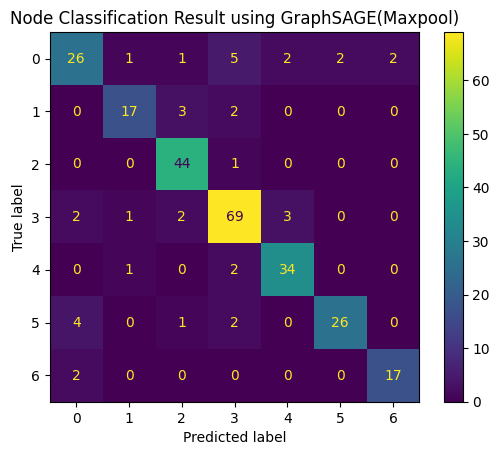

In [ ]:
evaluate_node_classification('maxpool', feat, edge, degree, label, idx_test,
                             title="Node Classification Result using GraphSAGE(Maxpool)")